In [1]:
import os
import cv2
import random
import shutil
import time
import matplotlib
import glob
import operator
import psutil
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Conv2D, MaxPooling2D, LeakyReLU, Flatten
from shutil import copyfile
import pandas as pd
import PIL
from mlxtend.plotting import plot_confusion_matrix

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
classify_train_dir = str(input("Classify Train Dir: "))
classify_train = os.path.join(classify_train_dir, 'classify train')

    
TRAINING_DIR = os.path.join(classify_train, 'training')
VALIDATION_DIR = os.path.join(classify_train, 'validation')
TESTING_DIR = os.path.join(classify_train, 'testing')

Classify Train Dir: /mnt/5cb8cb09-4047-4516-9429-8cb5922bb3d2/PROJECTS/PROJECTS/ML/Cough-COVID/my_coughvid/notebooks/mel_spectogram
/mnt/5cb8cb09-4047-4516-9429-8cb5922bb3d2/PROJECTS/PROJECTS/ML/Cough-COVID/my_coughvid/notebooks/mel_spectogram/classify train/testing
/mnt/5cb8cb09-4047-4516-9429-8cb5922bb3d2/PROJECTS/PROJECTS/ML/Cough-COVID/my_coughvid/notebooks/mel_spectogram/classify train/training
/mnt/5cb8cb09-4047-4516-9429-8cb5922bb3d2/PROJECTS/PROJECTS/ML/Cough-COVID/my_coughvid/notebooks/mel_spectogram/classify train/validation


In [5]:
TRAINING_DIR, VALIDATION_DIR, TESTING_DIR

('/mnt/5cb8cb09-4047-4516-9429-8cb5922bb3d2/PROJECTS/PROJECTS/ML/Cough-COVID/my_coughvid/notebooks/mel_spectogram/classify train/training',
 '/mnt/5cb8cb09-4047-4516-9429-8cb5922bb3d2/PROJECTS/PROJECTS/ML/Cough-COVID/my_coughvid/notebooks/mel_spectogram/classify train/validation',
 '/mnt/5cb8cb09-4047-4516-9429-8cb5922bb3d2/PROJECTS/PROJECTS/ML/Cough-COVID/my_coughvid/notebooks/mel_spectogram/classify train/testing')

In [7]:
learning_rate = float(input("Enter the initial learning rate: "))
epoch = int(input("Enter the maximum number of epochs: "))
batch_size = int(input("Enter batch size: "))

Enter the initial learning rate: 0.0001
Enter the maximum number of epochs: 100
Enter batch size: 16


In [8]:
char_name = str(input("Enter name of the characteristics folder: "))

char = os.path.join(classify_train_dir, char_name)

if not os.path.exists(char):
    os.mkdir(char)
else:
    replace = str(input("Folder already exists ! Do you want to replace it ?(Y/N) "))
    if replace.upper() == 'Y':      
        shutil.rmtree(char)
        os.mkdir(char)
    elif replace.upper() == 'N':
        pass

Enter name of sub-folder: 128x128
Enter name of the characteristics folder: mobilenet
Folder already exists ! Do you want to replace it ?(Y/N) y


In [9]:
def lr_schedule(epoch):
    return learning_rate * (0.1 ** int(epoch / 10))
    
best_model_address = os.path.join(char, 'best_model.h5')

In [10]:
monitor = int(input("Press 1 to monitor Validation Accuracy\nPress 2 to monitor Validation Loss\nPress 3 to monitor Training Accuracy\nPress 4 to monitor Training Loss\n"))
patience = int(input('Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: '))


if monitor == 1:
    metric = 'val_accuracy'
    mode = 'max'
    print("\nMONITORING VALIDATION ACCURACY..........\n")

elif monitor == 2:
    metric = 'val_loss'
    mode = 'min'
    print("\nMONITORING VALIDATION LOSS..........\n")

elif monitor == 3:
    metric = 'accuracy'
    mode = 'max'
    print("\nMONITORING TRAINING ACCURACY..........\n")

elif monitor == 4:
    metric = 'loss'
    mode = 'min'
    print("\nMONITORING TRAINING LOSS..........\n")

callback = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
            keras.callbacks.EarlyStopping(monitor = metric, min_delta = 0.001, patience = patience, verbose=1, mode = mode, restore_best_weights = True),
            keras.callbacks.ModelCheckpoint(best_model_address, monitor = metric, verbose=1, save_best_only=True, save_weights_only=False, mode = mode , period=1)]

print("\nTraining will stop if Validation Accuracy doesn't show any improvements for " + str(patience) + " epcohs\n")

Press 1 to monitor Validation Accuracy
Press 2 to monitor Validation Loss
Press 3 to monitor Training Accuracy
Press 4 to monitor Training Loss
4
Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: 10

MONITORING TRAINING LOSS..........


Training will stop if Validation Accuracy doesn't show any improvements for 10 epcohs



In [11]:
def MobileNet():
    print("\nTRAINING ON MobileNet MODEL:-")

    base_model = keras.applications.mobilenet.MobileNet(input_shape = dim, weights = 'imagenet', include_top = False)

    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(dense)(x)
    x = LeakyReLU()(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)

    predictions = Dense(output_layer, activation = output_activation)(x)

    model = Model(inputs = base_model.input, outputs=predictions)

    train_base_model = str(input("Do you want to train the base model of MobileNet?(Y/N) "))
    if train_base_model.upper() == 'Y':
        for layer in base_model.layers:
            layer.trainable = True
    elif train_base_model.upper() == 'N':
        for layer in base_model.layers:
            layer.trainable = False

    return model

In [13]:
class_no = len(os.listdir(TRAINING_DIR))

if class_no > 2:
    print("This is a " + str(class_no) + "-Class Classification")
    output_activation = 'softmax'
    losses = 'categorical_crossentropy'
    class_mode = 'categorical'
    output_layer = class_no
else:
    print("This is a Binary Classification")
    output_activation = 'sigmoid'
    losses = 'binary_crossentropy'
    class_mode = 'binary'
    output_layer = 1

This is a 3-Class Classification


In [14]:
def optimizer_selection():
    print("\nSelect a optimizer which will reduce the loss of the model.\n")

    optimizer_select = int(input("Press 1 to select Stochastic Gradient Descent\nPress 2 to select RMSprop\nPress 3 to select Adagrad\nPress 4 to select Adadelta\nPress 5 to select Adam\nPress 6 to select Adamax\nPress 7 to select Nadam\n"))

    if optimizer_select == 1:
        optimizer = SGD(lr = learning_rate, decay = 1e-6, momentum = 0.9, nesterov = True)

    elif optimizer_select == 2:
        optimizer = RMSprop(learning_rate, rho = 0.9)

    elif optimizer_select == 3:
        optimizer = Adagrad(learning_rate)

    elif optimizer_select == 4:
        optimizer = Adadelta(learning_rate, rho = 0.95)

    elif optimizer_select == 5:
        optimizer = Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

    elif optimizer_select == 6:
        optimizer = Adamax(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)

    elif optimizer_select == 7:
        optimizer = Nadam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)
   
    return optimizer

In [15]:
h = int(input("Image Dimension(H or W): "))
w = h
dim = [h,w,3]

Image Dimension(H or W): 128


In [16]:
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = batch_size,
                                                    class_mode = class_mode,
                                                    target_size = (h,w),
                                                    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size = batch_size,
                                                              class_mode = class_mode,
                                                              target_size = (h,w),
                                                              shuffle=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.)
test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size = batch_size,
                                                  class_mode = class_mode,
                                                  target_size = (h,w),
                                                  shuffle=True)

Found 2783 images belonging to 3 classes.
Found 27 images belonging to 3 classes.
Found 0 images belonging to 3 classes.


In [17]:
dense = int(input("Enter the no. of neurons in dense layer: "))
dropout = float(input("Enter the dropout percentage: "))
dropout = dropout/100

optimizer = optimizer_selection()

Enter the dropout percentage: 25

Select a optimizer which will reduce the loss of the model.

Press 1 to select Stochastic Gradient Descent
Press 2 to select RMSprop
Press 3 to select Adagrad
Press 4 to select Adadelta
Press 5 to select Adam
Press 6 to select Adamax
Press 7 to select Nadam
5


In [18]:
model= MobileNet()
model.compile(optimizer = optimizer, loss = losses, metrics = ['accuracy', 
                                                               tf.keras.metrics.Precision(), 
                                                               tf.keras.metrics.Recall(), 
                                                               tf.keras.metrics.TruePositives(), 
                                                               tf.keras.metrics.TrueNegatives(), 
                                                               tf.keras.metrics.FalsePositives(),
                                                               tf.keras.metrics.FalseNegatives()])


model.summary()


TRAINING ON MobileNet MODEL:-
Do you want to train the base model of MobileNet?(Y/N) y
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_______________________________________

In [19]:
with tf.device('/GPU:0'):
    start = time.time()
    history = model.fit(train_generator,
                        epochs = epoch,
                        verbose = 1,
                        callbacks = callback,
                        validation_data = validation_generator,
                        shuffle=True)

    end = time.time()
    duration = end-start

train_score = model.evaluate(train_generator)
val_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
174/174 [==============================] - 13s 45ms/step - loss: 1.4983 - accuracy: 0.3525 - precision: 0.3440 - recall: 0.2660 - true_positives: 378.0857 - true_negatives: 2112.7086 - false_positives: 702.3429 - false_negatives: 1029.4400 - val_loss: 1.2443 - val_accuracy: 0.2963 - val_precision: 0.4286 - val_recall: 0.2222 - val_true_positives: 6.0000 - val_true_negatives: 46.0000 - val_false_positives: 8.0000 - val_false_negatives: 21.0000

Epoch 00001: loss improved from inf to 1.45448, saving model to /mnt/5cb8cb09-4047-4516-9429-8cb5922bb3d2/PROJECTS/PROJECTS/ML/Cough-COVID/my_coughvid/notebooks/mel_spectogram/128x128/mobilenet/best_model.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
174/174 [==============================] - 6s 36ms/step - loss: 1.1979 - accuracy: 0.4197 - precision: 0.4487 - recall: 0.3347 - true_positives: 463.6629 - true_negatives: 2235.434

174/174 [==============================] - 7s 37ms/step - loss: 0.1938 - accuracy: 0.9390 - precision: 0.9492 - recall: 0.9238 - true_positives: 1304.6057 - true_negatives: 2747.9486 - false_positives: 67.6971 - false_negatives: 103.2171 - val_loss: 1.8265 - val_accuracy: 0.2963 - val_precision: 0.3200 - val_recall: 0.2963 - val_true_positives: 8.0000 - val_true_negatives: 37.0000 - val_false_positives: 17.0000 - val_false_negatives: 19.0000

Epoch 00012: loss improved from 0.19609 to 0.18366, saving model to /mnt/5cb8cb09-4047-4516-9429-8cb5922bb3d2/PROJECTS/PROJECTS/ML/Cough-COVID/my_coughvid/notebooks/mel_spectogram/128x128/mobilenet/best_model.h5
Epoch 13/100

Epoch 00013: LearningRateScheduler reducing learning rate to 1e-05.
174/174 [==============================] - 6s 37ms/step - loss: 0.1500 - accuracy: 0.9580 - precision: 0.9694 - recall: 0.9508 - true_positives: 1339.2914 - true_negatives: 2772.1200 - false_positives: 42.3371 - false_negatives: 67.9371 - val_loss: 1.7612 - v

174/174 [==============================] - 6s 36ms/step - loss: 0.0916 - accuracy: 0.9862 - precision: 0.9879 - recall: 0.9824 - true_positives: 1381.4914 - true_negatives: 2796.8514 - false_positives: 17.6857 - false_negatives: 25.7771 - val_loss: 1.9274 - val_accuracy: 0.2593 - val_precision: 0.2692 - val_recall: 0.2593 - val_true_positives: 7.0000 - val_true_negatives: 35.0000 - val_false_positives: 19.0000 - val_false_negatives: 20.0000

Epoch 00024: loss did not improve from 0.09233
Epoch 25/100

Epoch 00025: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
174/174 [==============================] - 6s 37ms/step - loss: 0.1000 - accuracy: 0.9768 - precision: 0.9786 - recall: 0.9705 - true_positives: 1369.0971 - true_negatives: 2787.2286 - false_positives: 28.4971 - false_negatives: 38.7657 - val_loss: 1.9114 - val_accuracy: 0.2593 - val_precision: 0.2800 - val_recall: 0.2593 - val_true_positives: 7.0000 - val_true_negatives: 36.0000 - val_false_positives: 18


Epoch 00037: loss did not improve from 0.08649
Epoch 38/100

Epoch 00038: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
174/174 [==============================] - 6s 36ms/step - loss: 0.0953 - accuracy: 0.9741 - precision: 0.9778 - recall: 0.9719 - true_positives: 1367.0971 - true_negatives: 2783.4800 - false_positives: 31.0914 - false_negatives: 40.1886 - val_loss: 1.9310 - val_accuracy: 0.2963 - val_precision: 0.2963 - val_recall: 0.2963 - val_true_positives: 8.0000 - val_true_negatives: 35.0000 - val_false_positives: 19.0000 - val_false_negatives: 19.0000

Epoch 00038: loss did not improve from 0.08649
Epoch 39/100

Epoch 00039: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
174/174 [==============================] - 6s 36ms/step - loss: 0.1000 - accuracy: 0.9783 - precision: 0.9789 - recall: 0.9741 - true_positives: 1371.8286 - true_negatives: 2785.6057 - false_positives: 29.1943 - false_negatives: 35.5714 - val_loss: 1.9409 - val

In [20]:
print("Execution Time: {} seconds".format(duration))

Execution Time: 277.33719754219055 seconds


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


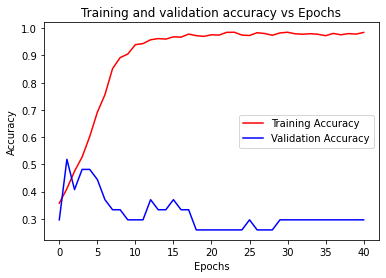

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


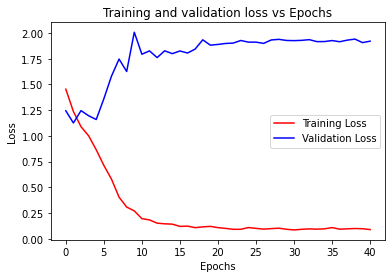

In [21]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy vs Epochs')
plt.legend()
accuracy_fig_name = "accuracy.eps"
plt.savefig(os.path.join(char, accuracy_fig_name))
plt.show()


plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss vs Epochs')
plt.legend()
loss_fig_name = "loss.eps"

plt.savefig(os.path.join(char, loss_fig_name))
plt.show()

In [22]:
training_accuracy = train_score[1]*100
validation_accuracy = val_score[1]*100
# test_accuracy = test_score[1]*100

print("The training accuracy is: " + str(training_accuracy) + ' %')
print("The validation accuracy is: " + str(validation_accuracy) + ' %')
# print("The test accuracy is: " + str(test_accuracy) + ' %')

The training accuracy is: 100.0 %
The validation accuracy is: 29.629629850387573 %


In [23]:
test_accuracy = train_score[1]*100
test_precision = train_score[2]*100
test_recall = train_score[3]*100
tp = int(train_score[4])
tn = int(train_score[5])
fp = int(train_score[6])
fn = int(train_score[7])

f1 = 2*((test_precision*test_recall)/(test_precision+test_recall))
sensitivity = (tp/(tp+fn))*100
specificity = (tn/(tn+fp))*100

In [24]:
test_accuracy = test_score[1]*100
test_precision = test_score[2]*100
test_recall = test_score[3]*100
tp = int(test_score[4])
tn = int(test_score[5])
fp = int(test_score[6])
fn = int(test_score[7])

f1 = 2*((test_precision*test_recall)/(test_precision+test_recall))
sensitivity = (tp/(tp+fn))*100
specificity = (tn/(tn+fp))*100

In [25]:
print("Test Accuracy: {}".format(test_accuracy))
print("Test Precision: {}".format(test_precision))
print("Test Recall: {}".format(test_recall))
print("True Positive: {}".format(tp))
print("Test Negetive: {}".format(tn))
print("False Positive: {}".format(fp))
print("False Negetive: {}".format(fn))
print("Sensitivity: {}".format(sensitivity))
print("Specificity: {}".format(specificity))

Test Accuracy: 100.0
Test Precision: 100.0
Test Recall: 100.0
True Positive: 2783
Test Negetive: 5566
False Positive: 0
False Negetive: 0
Sensitivity: 100.0
Specificity: 100.0


In [ ]:
from contextlib import redirect_stdout

readme_name_text = "readme.txt"
print("Please read the text file named " + readme_name_text + " for detailed information of the model.")

completeName_txt = os.path.join(char, readme_name_text) 

readme = open(completeName_txt, "w")

if len(os.listdir(TRAINING_DIR)) > 2:
    readme.write("This is a MULTICLASS CLASSIFICATION")
else:
    readme.write("This is a BINARY CLASSIFICATION")


readme.write("\n\n--HYPERPARAMETERS--\n")
readme.write(str(augmentation))
readme.write("\nInitial Learning Rate = " + str(learning_rate))
readme.write("\nNo. of epochs = " + str(len(acc)))
readme.write("\nBatch Size = " + str(batch_size))


readme.write("\n\n--MODEL-PARAMETERS--")
readme.write("\nActivation Function = relu")
readme.write("\nDropout = " + str(int(dropout*100)) + "%")
readme.write("\nActivation function of the output layer = " + str(output_activation))
readme.write("\nCost function of the model = " + str(losses))
readme.write("\nOptimizer = " + str(optimizer) + "\n\n")


readme.write("Trained on a Mobilenet Model\n")
with redirect_stdout(readme):
    model.summary()
        
    
readme.write("\n\n--MODEL-PERFORMANCE--")
readme.write("\nTest Accuracy = " + str(test_accuracy) + " %")
readme.write("\nTest Precision = " + str(test_precision) + " %")
readme.write("\nTest Recall = " + str(test_recall) + " %")
readme.write("\nTrue Positive = " + str(tp))
readme.write("\nTrue Negetive = " + str(tn))
readme.write("\nFalse Positive = " + str(fp))
readme.write("\nFalse Negetive = " + str(fn))
readme.write("\nSensitivity = " + str(sensitivity))
readme.write("\nSpecificity = " + str(specificity) + " \n\n\n")


readme.write("\n\n--MODEL-CHARACTERISTICS--")
readme.write("\nacc = " + str(acc))
readme.write("\n\nval_acc = " + str(val_acc))
readme.write("\n\nloss = " + str(loss))
readme.write("\n\nval_loss = " + str(val_loss))


readme.write("\nExecution Time: {} seconds".format(duration))

readme.write("\n\nCreated using Self-Regulated Image Classifier using Convolution Neural Network")

readme.close()